<a href="https://colab.research.google.com/github/takashi4488/rabbit_challenge/blob/main/Day4_repoty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section1 強化学習

# モジュールのロード

In [10]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# データのロード

In [11]:
tf_flowers = tfds.image_classification.TFFlowers()
tf_flowers.download_and_prepare()

In [12]:
(train_ds, test_ds) = tf_flowers.as_dataset(as_supervised=True, split=['train[:70%]', 'train[70%:]'], shuffle_files=True)

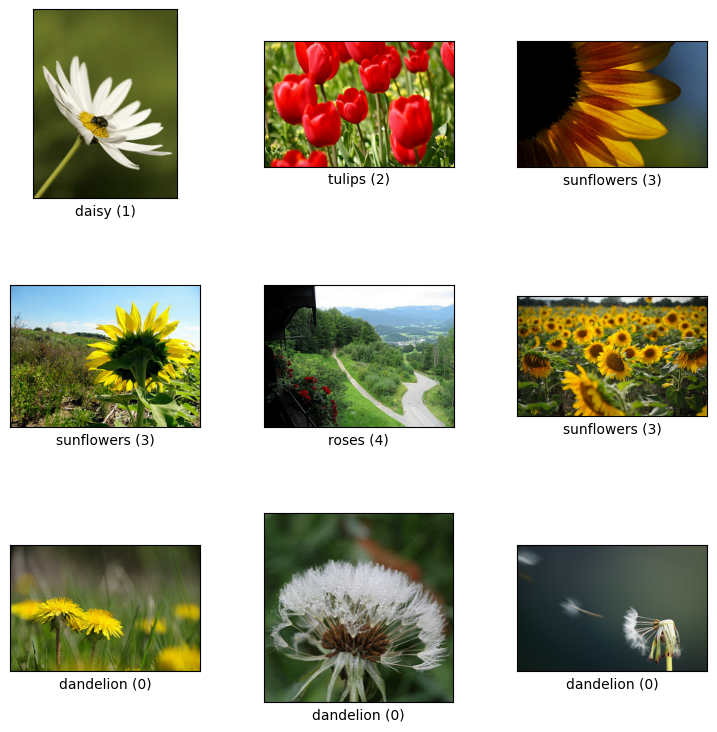

In [13]:
fig = tfds.show_examples(train_ds, tf_flowers.info)

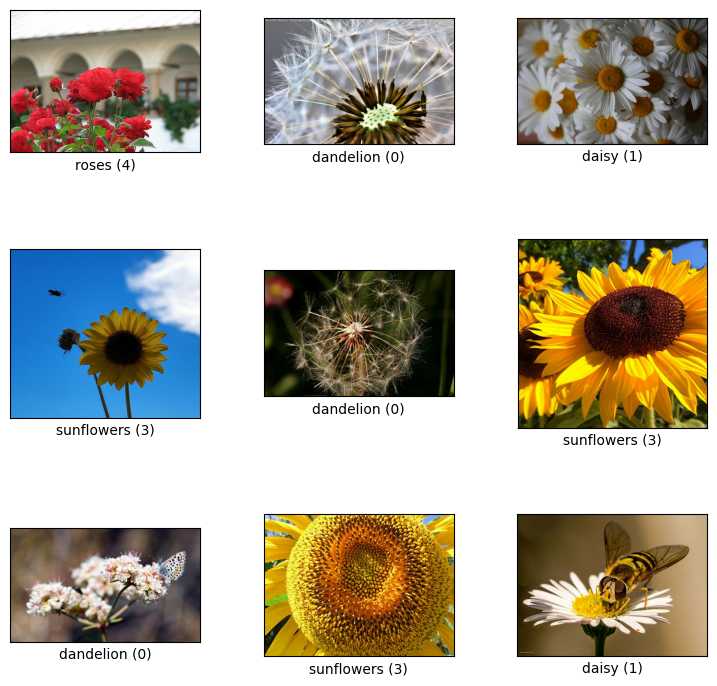

In [14]:
fig = tfds.show_examples(test_ds, tf_flowers.info)

In [15]:
class_num = tf_flowers.info.features['label'].num_classes
class_num

5

In [16]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    label = tf.one_hot(label, depth=class_num)

    return image, label

BATCH_SIZE = 16

train_batches = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(test_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


# 事前学習なしでResNetを利用する

In [17]:
resnet = tf.keras.applications.resnet.ResNet50(weights=None)
resnet.trainable = True
x1 = resnet.layers[-2].output # avg_poolまでのoutputを取得します。
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1) # avg_poolから出力層に繋げます。
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
histories = []

In [19]:
EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 123s 388ms/step - acc: 0.3876 - loss: 1.5931 - val_acc: 0.2352 - val_loss: 6.9488
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - acc: 0.5221 - loss: 1.2320 - val_acc: 0.2352 - val_loss: 7.1982
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - acc: 0.5528 - loss: 1.1585 - val_acc: 0.3451 - val_loss: 2.0093
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - acc: 0.5662 - loss: 1.0712 - val_acc: 0.4687 - val_loss: 1.4879
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - acc: 0.5977 - loss: 1.0416 - val_acc: 0.4296 - val_loss: 2.6789
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - acc: 0.6390 - loss: 0.9489 - val_acc: 0.4914 - val_loss: 2.2212
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 194ms/step - acc: 0.6590 - loss: 0.8907 - val_acc: 0.5577 - val_loss: 1.4925
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - acc: 0.7037 - loss: 0.7805 - val_acc: 0.5431 - val_loss: 1.5588
Epoch 9/20
161/161 ━━━━━━━━━━━━

# ImageNetによる事前学習を利用する(Weightを再利用、事前学習部分は固定)

In [20]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet')
resnet.trainable = False
x1 = resnet.layers[-2].output # avg_poolまでのoutputを取得します。
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1) # avg_poolから出力層に繋げます。
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - acc: 0.2140 - loss: 1.8403 - val_acc: 0.2825 - val_loss: 1.5917
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - acc: 0.2833 - loss: 1.5847 - val_acc: 0.2961 - val_loss: 1.5714
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - acc: 0.3068 - loss: 1.5642 - val_acc: 0.3088 - val_loss: 1.5545
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - acc: 0.3191 - loss: 1.5488 - val_acc: 0.3115 - val_loss: 1.5407
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - acc: 0.3275 - loss: 1.5359 - val_acc: 0.3161 - val_loss: 1.5294
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - acc: 0.3414 - loss: 1.5244 - val_acc: 0.3233 - val_loss: 1.5199
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - acc: 0.3510 - loss: 1.5165 - val_acc: 0.3297 - val_loss: 1.5118
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - acc: 0.3604 - loss: 1.5088 - val_acc: 0.3342 - val_loss: 1.5047
Epoch 9/20
161/161 ━━━━━━━━━━━━━━━━━━━━

# ImageNetによる事前学習を利用する(ファインチューニングあり)

In [22]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet')
resnet.trainable = True
x1 = resnet.layers[-2].output
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1)
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [23]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 106s 350ms/step - acc: 0.7643 - loss: 0.6318 - val_acc: 0.2243 - val_loss: 2.0457
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - acc: 0.9783 - loss: 0.0790 - val_acc: 0.2888 - val_loss: 1.7693
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - acc: 0.9943 - loss: 0.0226 - val_acc: 0.3806 - val_loss: 2.0230
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - acc: 0.9997 - loss: 0.0048 - val_acc: 0.6585 - val_loss: 1.2046
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - acc: 1.0000 - loss: 9.6647e-04 - val_acc: 0.8401 - val_loss: 0.5792
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 193ms/step - acc: 1.0000 - loss: 4.8712e-04 - val_acc: 0.9210 - val_loss: 0.2867
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - acc: 1.0000 - loss: 3.5069e-04 - val_acc: 0.9464 - val_loss: 0.1876
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - acc: 1.0000 - loss: 2.6825e-04 - val_acc: 0.9455 - val_loss: 0.1727
Epoch 9/20
161/

# それぞれの学習曲線を確認する

<Axes: xlabel='Epochs', ylabel='acc'>

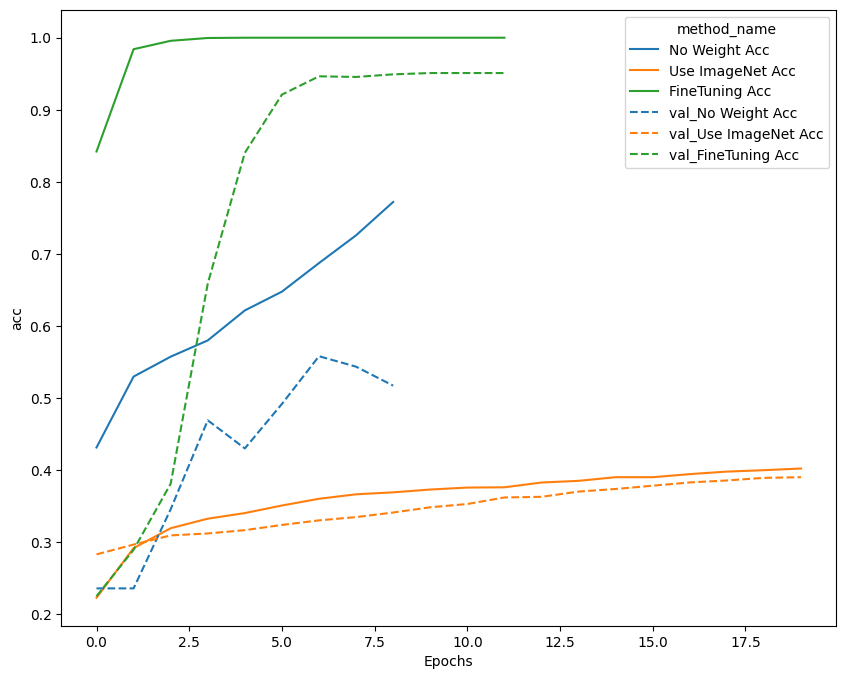

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
method_names = [
                'No Weight Acc',
                'Use ImageNet Acc',
                'FineTuning Acc'
]

plot_df = pd.DataFrame()

for i, history in enumerate(histories):
    method_name = str(method_names[i])
    history_df = pd.DataFrame(history.history)
    history_df['method_name'] = method_name
    history_df['Epochs'] = history_df.index
    plot_df = pd.concat([plot_df, history_df], ignore_index= True)

sns.lineplot(data=plot_df, x=plot_df['Epochs'], y='acc', hue='method_name')
val_plot_df = plot_df
val_plot_df['method_name'] = plot_df['method_name'].apply(lambda x: 'val_' + x)
sns.lineplot(data=val_plot_df, x=plot_df['Epochs'], y='val_acc', hue='method_name', linestyle='dashed')

#アルファ碁の技術を復習

In [44]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import math
import random

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. ゲーム環境（三目並べ）
# ==========================================
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=np.int8)
        self.current_player = 1  # 1 or -1

    def clone(self):
        new_game = TicTacToe()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def get_valid_moves(self):
        moves = []
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 0:
                    moves.append((i, j))
        return moves

    def make_move(self, move):
        i, j = move
        if self.board[i, j] != 0:
            return False
        self.board[i, j] = self.current_player
        self.current_player *= -1
        return True

    def check_winner(self):
        # 行・列・対角線をチェック
        for i in range(3):
            if abs(self.board[i, :].sum()) == 3:
                return self.board[i, 0]
            if abs(self.board[:, i].sum()) == 3:
                return self.board[0, i]
        if abs(self.board.trace()) == 3:
            return self.board[0, 0]
        if abs(np.fliplr(self.board).trace()) == 3:
            return self.board[0, 2]
        return 0

    def is_terminal(self):
        return self.check_winner() != 0 or len(self.get_valid_moves()) == 0

    def get_state(self):
        # ニューラルネット用: [自分の石, 相手の石] の2チャンネル
        state = np.zeros((2, 3, 3), dtype=np.float32)
        state[0] = (self.board == self.current_player)
        state[1] = (self.board == -self.current_player)
        return state


# ==========================================
# 2. Policy-Value Network（AlphaGoの核心）
# ==========================================
class PolicyValueNetwork(nn.Module):
    """
    AlphaGoスタイルのネットワーク
    - Policy Head: 各手の確率を出力
    - Value Head: 現在の局面の勝率を出力
    """
    def __init__(self):
        super().__init__()
        # 共通の畳み込み層
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Policy Head（方策）
        self.policy_conv = nn.Conv2d(64, 2, kernel_size=1)
        self.policy_fc = nn.Linear(2 * 3 * 3, 9)

        # Value Head（価値）
        self.value_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.value_fc1 = nn.Linear(1 * 3 * 3, 64)
        self.value_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # 共通部分
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Policy Head
        p = F.relu(self.policy_conv(x))
        p = p.view(-1, 2 * 3 * 3)
        p = self.policy_fc(p)
        policy = F.softmax(p, dim=1)

        # Value Head
        v = F.relu(self.value_conv(x))
        v = v.view(-1, 1 * 3 * 3)
        v = F.relu(self.value_fc1(v))
        value = torch.tanh(self.value_fc2(v))

        return policy, value


# ==========================================
# 3. モンテカルロ木探索（MCTS）
# ==========================================
class MCTSNode:
    def __init__(self, game, parent=None, move=None, prior=0):
        self.game = game
        self.parent = parent
        self.move = move
        self.prior = prior  # ニューラルネットからの事前確率
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def is_expanded(self):
        return len(self.children) > 0


class MCTS:
    def __init__(self, network, num_simulations=100, c_puct=1.4):
        self.network = network
        self.num_simulations = num_simulations
        self.c_puct = c_puct  # 探索と活用のバランス

    def search(self, game):
        root = MCTSNode(game.clone())

        # ルートノードを展開
        self._expand(root)

        for _ in range(self.num_simulations):
            node = root
            search_path = [node]

            # Selection: UCBスコアで最良の子を選択
            while node.is_expanded() and not node.game.is_terminal():
                node = self._select_child(node)
                search_path.append(node)

            # Expansion & Evaluation
            if not node.game.is_terminal():
                self._expand(node)
                value = self._evaluate(node)
            else:
                # 終端ノードは実際の結果を使用
                winner = node.game.check_winner()
                value = winner * node.game.current_player * -1

            # Backpropagation
            self._backpropagate(search_path, value)

        return root

    def _select_child(self, node):
        best_score = -float('inf')
        best_child = None

        for child in node.children.values():
            # UCB スコア（AlphaGoスタイル）
            ucb = child.value() + self.c_puct * child.prior * \
                  math.sqrt(node.visit_count) / (1 + child.visit_count)
            if ucb > best_score:
                best_score = ucb
                best_child = child

        return best_child

    def _expand(self, node):
        state = torch.FloatTensor(node.game.get_state()).unsqueeze(0).to(device)
        with torch.no_grad():
            policy, _ = self.network(state)
        policy = policy.cpu().numpy()[0]

        valid_moves = node.game.get_valid_moves()
        for move in valid_moves:
            idx = move[0] * 3 + move[1]
            child_game = node.game.clone()
            child_game.make_move(move)
            node.children[move] = MCTSNode(
                child_game, parent=node, move=move, prior=policy[idx]
            )

    def _evaluate(self, node):
        state = torch.FloatTensor(node.game.get_state()).unsqueeze(0).to(device)
        with torch.no_grad():
            _, value = self.network(state)
        return value.item()

    def _backpropagate(self, search_path, value):
        for node in reversed(search_path):
            node.visit_count += 1
            # 手番が変わるので符号を反転
            node.value_sum += value
            value = -value

    def get_action_probs(self, game, temperature=1.0):
        root = self.search(game)

        visits = np.zeros(9)
        for move, child in root.children.items():
            idx = move[0] * 3 + move[1]
            visits[idx] = child.visit_count

        if temperature == 0:
            # 最も訪問回数の多い手を選択
            probs = np.zeros(9)
            probs[np.argmax(visits)] = 1
        else:
            visits = visits ** (1 / temperature)
            probs = visits / visits.sum()

        return probs


# ==========================================
# 4. 自己対戦による学習
# ==========================================
def self_play(mcts, num_games=10):
    """自己対戦でデータを生成"""
    training_data = []

    for game_idx in range(num_games):
        game = TicTacToe()
        game_history = []

        while not game.is_terminal():
            state = game.get_state()
            probs = mcts.get_action_probs(game, temperature=1.0)

            game_history.append((state, probs, game.current_player))

            # 確率に従って手を選択
            valid_moves = game.get_valid_moves()
            valid_probs = []
            for move in valid_moves:
                idx = move[0] * 3 + move[1]
                valid_probs.append(probs[idx])
            valid_probs = np.array(valid_probs)
            valid_probs /= valid_probs.sum()

            move_idx = np.random.choice(len(valid_moves), p=valid_probs)
            game.make_move(valid_moves[move_idx])

        # 勝者を取得
        winner = game.check_winner()

        # 学習データに変換
        for state, probs, player in game_history:
            value = winner * player  # その手番から見た結果
            training_data.append((state, probs, value))

    return training_data


def train_network(network, training_data, epochs=5, batch_size=32):
    """ネットワークを学習"""
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

    for epoch in range(epochs):
        random.shuffle(training_data)
        total_loss = 0

        for i in range(0, len(training_data), batch_size):
            batch = training_data[i:i+batch_size]
            states = torch.FloatTensor([d[0] for d in batch]).to(device)
            target_probs = torch.FloatTensor([d[1] for d in batch]).to(device)
            target_values = torch.FloatTensor([[d[2]] for d in batch]).to(device)

            policy, value = network(states)

            # 損失計算
            policy_loss = -torch.sum(target_probs * torch.log(policy + 1e-8)) / len(batch)
            value_loss = F.mse_loss(value, target_values)
            loss = policy_loss + value_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# ==========================================
# 5. 実行デモ
# ==========================================
print("=" * 50)
print("AlphaGo技術のデモ（三目並べ）")
print("=" * 50)

# ネットワーク初期化
network = PolicyValueNetwork().to(device)
mcts = MCTS(network, num_simulations=50)

# 学習ループ
for iteration in range(3):
    print(f"\n--- Iteration {iteration + 1} ---")

    # 自己対戦
    print("自己対戦中...")
    data = self_play(mcts, num_games=20)
    print(f"生成データ数: {len(data)}")

    # 学習
    print("学習中...")
    train_network(network, data, epochs=3)

# AIと対戦
print("\n" + "=" * 50)
print("AIと対戦！（あなたは X、AIは O）")
print("=" * 50)

def print_board(board):
    symbols = {0: ".", 1: "X", -1: "O"}
    print("\n  0 1 2")
    for i in range(3):
        row = " ".join(symbols[board[i, j]] for j in range(3))
        print(f"{i} {row}")
    print()

game = TicTacToe()
print_board(game.board)

while not game.is_terminal():
    if game.current_player == 1:
        # 人間の手番
        valid = game.get_valid_moves()
        print(f"有効な手: {valid}")
        try:
            move = input("あなたの手 (row col): ").split()
            move = (int(move[0]), int(move[1]))
            if move not in valid:
                print("無効な手です")
                continue
        except:
            print("入力エラー。例: 1 1")
            continue
    else:
        # AIの手番
        print("AIが考え中...")
        probs = mcts.get_action_probs(game, temperature=0.5)
        best_idx = np.argmax(probs)
        move = (best_idx // 3, best_idx % 3)
        print(f"AIの手: {move}")

    game.make_move(move)
    print_board(game.board)

winner = game.check_winner()
if winner == 1:
    print("あなたの勝ち！")
elif winner == -1:
    print("AIの勝ち！")
else:
    print("引き分け！")

Using device: cuda
AlphaGo技術のデモ（三目並べ）

--- Iteration 1 ---
自己対戦中...
生成データ数: 145
学習中...


/tmp/ipython-input-66748930.py:281: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([d[0] for d in batch]).to(device)


Epoch 1, Loss: 14.7599
Epoch 2, Loss: 14.7341
Epoch 3, Loss: 14.6250

--- Iteration 2 ---
自己対戦中...
生成データ数: 141
学習中...
Epoch 1, Loss: 14.9884
Epoch 2, Loss: 14.6816
Epoch 3, Loss: 14.7628

--- Iteration 3 ---
自己対戦中...
生成データ数: 149
学習中...
Epoch 1, Loss: 14.3323
Epoch 2, Loss: 14.1743
Epoch 3, Loss: 13.9520

AIと対戦！（あなたは X、AIは O）

  0 1 2
0 . . .
1 . . .
2 . . .

有効な手: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
あなたの手 (row col): (0,0)
入力エラー。例: 1 1
有効な手: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
あなたの手 (row col): 1 1

  0 1 2
0 . . .
1 . X .
2 . . .

AIが考え中...
AIの手: (np.int64(1), np.int64(2))

  0 1 2
0 . . .
1 . X O
2 . . .

有効な手: [(0, 0), (0, 1), (0, 2), (1, 0), (2, 0), (2, 1), (2, 2)]
あなたの手 (row col): 0 0

  0 1 2
0 X . .
1 . X O
2 . . .

AIが考え中...
AIの手: (np.int64(2), np.int64(2))

  0 1 2
0 X . .
1 . X O
2 . . O

有効な手: [(0, 1), (0, 2), (1, 0), (2, 0), (2, 1)]
あなたの手 (row col): 0 2

  0 1 2
0 X . X
1 . X O
2 . . O

AIが考え中...
AIの手: 

#軽量化・高速化技術

In [47]:
# 必要なライブラリのインストール
!pip install torch torchvision -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import copy
import os

# GPU設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ==========================================
# ベースモデル（CNN）の定義
# ==========================================
class BaseCNN(nn.Module):
    """標準的なCNNモデル"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.reshape(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# ==========================================
# データセット準備
# ==========================================
print("\n" + "="*60)
print("データセット準備")
print("="*60)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"訓練データ: {len(train_dataset)}, テストデータ: {len(test_dataset)}")


# ==========================================
# ユーティリティ関数
# ==========================================
def train_model(model, train_loader, epochs=3, lr=0.001):
    """モデルを訓練"""
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


def evaluate_model(model, test_loader):
    """精度を測定"""
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def count_parameters(model):
    """パラメータ数をカウント"""
    return sum(p.numel() for p in model.parameters())


def get_model_size(model):
    """モデルサイズをMBで取得"""
    torch.save(model.state_dict(), "temp_model.pt")
    size_mb = os.path.getsize("temp_model.pt") / (1024 * 1024)
    os.remove("temp_model.pt")
    return size_mb


# ==========================================
# 1. ベースラインモデルの訓練
# ==========================================
print("\n" + "="*60)
print("1. ベースラインモデル")
print("="*60)

base_model = BaseCNN()
print("訓練中...")
train_model(base_model, train_loader, epochs=3)

base_accuracy = evaluate_model(base_model, test_loader)
base_params = count_parameters(base_model)
base_size = get_model_size(base_model)

print(f"\n[ベースライン結果]")
print(f"  精度: {base_accuracy:.2f}%")
print(f"  パラメータ数: {base_params:,}")
print(f"  モデルサイズ: {base_size:.2f}MB")


# ==========================================
# 2. 知識蒸留（Knowledge Distillation）
# ==========================================
print("\n" + "="*60)
print("2. 知識蒸留（Knowledge Distillation）")
print("="*60)

class StudentCNN(nn.Module):
    """軽量な生徒モデル"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    """蒸留損失"""
    soft_targets = F.softmax(teacher_logits / temperature, dim=1)
    soft_student = F.log_softmax(student_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_student, soft_targets, reduction='batchmean') * (temperature ** 2)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * hard_loss


def train_with_distillation(teacher, student, train_loader, epochs=3):
    """知識蒸留で生徒モデルを訓練"""
    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher(images)

            optimizer.zero_grad()
            student_logits = student(images)
            loss = distillation_loss(student_logits, teacher_logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


student_model = StudentCNN()
print("知識蒸留で訓練中...")
train_with_distillation(base_model, student_model, train_loader, epochs=3)

student_accuracy = evaluate_model(student_model, test_loader)
student_params = count_parameters(student_model)
student_size = get_model_size(student_model)

print(f"\n[知識蒸留結果]")
print(f"  精度: {student_accuracy:.2f}% (ベースライン比: {student_accuracy - base_accuracy:+.2f}%)")
print(f"  パラメータ数: {student_params:,} ({student_params/base_params*100:.1f}%)")
print(f"  モデルサイズ: {student_size:.2f}MB ({student_size/base_size*100:.1f}%)")


# ==========================================
# 3. プルーニング（Pruning）
# ==========================================
print("\n" + "="*60)
print("3. プルーニング（Pruning）")
print("="*60)

import torch.nn.utils.prune as prune

def apply_pruning(model, amount=0.3):
    """重みの一定割合をプルーニング"""
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model


def count_zero_weights(model):
    """ゼロ重みの割合を計算"""
    total = 0
    zeros = 0
    for param in model.parameters():
        total += param.numel()
        zeros += (param == 0).sum().item()
    return zeros / total * 100


pruning_rates = [0.3, 0.5, 0.7]
print("\n異なるプルーニング率での結果:")

for rate in pruning_rates:
    pruned_model = copy.deepcopy(base_model)
    apply_pruning(pruned_model, amount=rate)

    # プルーニング後の再訓練
    pruned_model.to(device)
    pruned_model.train()
    optimizer = torch.optim.Adam(pruned_model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    for images, labels in list(train_loader)[:50]:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pruned_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    pruned_accuracy = evaluate_model(pruned_model, test_loader)
    sparsity = count_zero_weights(pruned_model)

    print(f"\n  プルーニング率 {rate*100:.0f}%:")
    print(f"    精度: {pruned_accuracy:.2f}%")
    print(f"    スパース率: {sparsity:.1f}%")


# ==========================================
# 4. Depthwise Separable Convolution
# ==========================================
print("\n" + "="*60)
print("4. Depthwise Separable Convolution（MobileNet式）")
print("="*60)

class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size,
            padding=padding, groups=in_channels
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class EfficientCNN(nn.Module):
    """Depthwise Separable Convを使った軽量モデル"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.dsconv2 = DepthwiseSeparableConv(32, 64)
        self.dsconv3 = DepthwiseSeparableConv(64, 128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.dsconv2(x)))
        x = self.pool(F.relu(self.dsconv3(x)))
        x = x.reshape(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


efficient_model = EfficientCNN()
print("Efficient CNN訓練中...")
train_model(efficient_model, train_loader, epochs=3)

efficient_accuracy = evaluate_model(efficient_model, test_loader)
efficient_params = count_parameters(efficient_model)
efficient_size = get_model_size(efficient_model)

print(f"\n[Depthwise Separable Conv結果]")
print(f"  精度: {efficient_accuracy:.2f}%")
print(f"  パラメータ数: {efficient_params:,} ({efficient_params/base_params*100:.1f}%)")
print(f"  モデルサイズ: {efficient_size:.2f}MB ({efficient_size/base_size*100:.1f}%)")


# ==========================================
# 5. 結果サマリー
# ==========================================
print("\n" + "="*60)
print("📊 軽量化技術の比較サマリー")
print("="*60)

results = [
    ("ベースライン", base_accuracy, base_params, base_size, 1.0),
    ("知識蒸留", student_accuracy, student_params, student_size, student_params/base_params),
    ("DSConv", efficient_accuracy, efficient_params, efficient_size, efficient_params/base_params),
]

print(f"\n{'手法':<15} {'精度':>8} {'パラメータ':>12} {'サイズ':>10} {'圧縮率':>8}")
print("-" * 60)
for name, acc, params, size, ratio in results:
    print(f"{name:<15} {acc:>7.2f}% {params:>11,} {size:>9.2f}MB {ratio:>7.1%}")

print("\n✅ 全てのデモが完了しました！")

Device: cuda

データセット準備
訓練データ: 60000, テストデータ: 10000

1. ベースラインモデル
訓練中...
  Epoch 1/3, Loss: 0.2163
  Epoch 2/3, Loss: 0.0592
  Epoch 3/3, Loss: 0.0442

[ベースライン結果]
  精度: 99.10%
  パラメータ数: 390,410
  モデルサイズ: 1.49MB

2. 知識蒸留（Knowledge Distillation）
知識蒸留で訓練中...
  Epoch 1/3, Loss: 1.8347
  Epoch 2/3, Loss: 0.2666
  Epoch 3/3, Loss: 0.1792

[知識蒸留結果]
  精度: 98.86% (ベースライン比: -0.24%)
  パラメータ数: 105,866 (27.1%)
  モデルサイズ: 0.41MB (27.3%)

3. プルーニング（Pruning）

異なるプルーニング率での結果:

  プルーニング率 30%:
    精度: 99.34%
    スパース率: 0.0%

  プルーニング率 50%:
    精度: 99.26%
    スパース率: 0.0%

  プルーニング率 70%:
    精度: 98.64%
    スパース率: 0.0%

4. Depthwise Separable Convolution（MobileNet式）
Efficient CNN訓練中...
  Epoch 1/3, Loss: 0.3482
  Epoch 2/3, Loss: 0.0716
  Epoch 3/3, Loss: 0.0494

[Depthwise Separable Conv結果]
  精度: 98.61%
  パラメータ数: 309,450 (79.3%)
  モデルサイズ: 1.19MB (79.4%)

📊 軽量化技術の比較サマリー

手法                    精度        パラメータ        サイズ      圧縮率
------------------------------------------------------------
ベースライン            99.

#ResNet(Residual Neural Network)

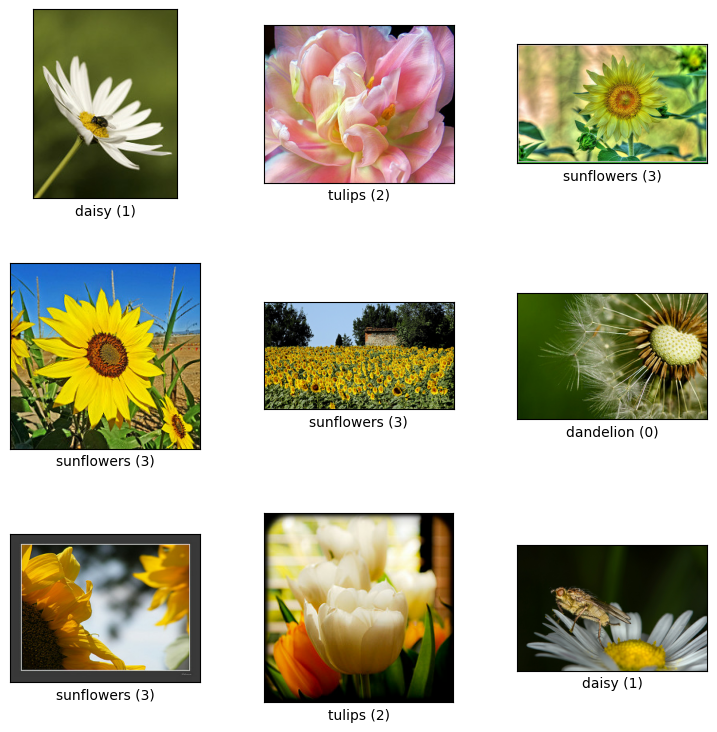

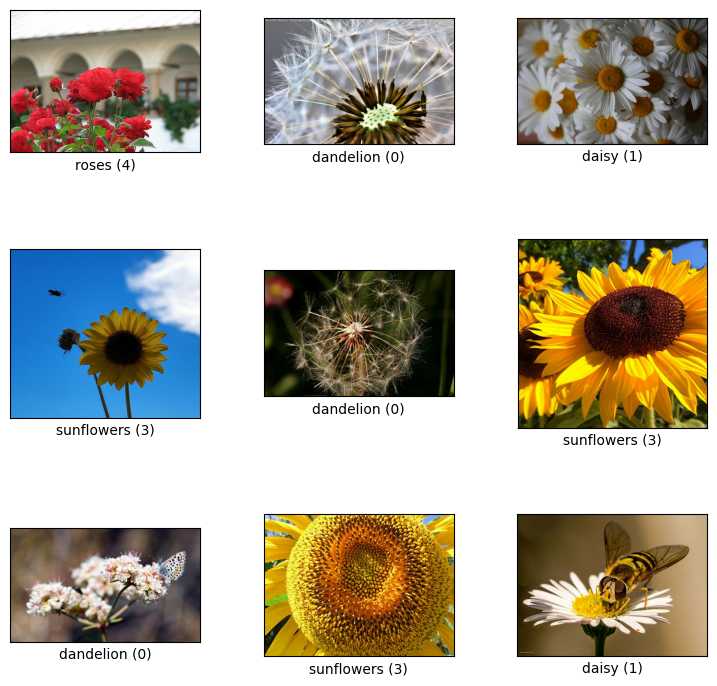

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 142ms/step - acc: 0.6685 - loss: 0.8524 - val_acc: 0.8974 - val_loss: 0.3158
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - acc: 0.9229 - loss: 0.2401 - val_acc: 0.9137 - val_loss: 0.2718
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - acc: 0.9599 - loss: 0.1568 - val_acc: 0.9164 - val_loss: 0.2634
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - acc: 0.9761 - loss: 0.1149 - val_acc: 0.9219 - val_loss: 0.2568
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - acc: 0.9848 - loss: 0.0883 - val_acc: 0.9246 - val_loss: 0.2542
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - acc: 0.9900 - loss: 0.0697 - val_acc: 0.9273 - val_loss: 0.2527
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - acc: 0.9929 - loss: 0.0559 - val_acc: 0.9273 - val_loss: 0.2524
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - acc: 0.9944 - loss: 0.0456 - val_acc: 0.9264 - val_loss: 0.2532


In [25]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# データセットの読み込み
(train_ds, test_ds), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True
)

# サンプル画像の表示
fig = tfds.show_examples(train_ds, info)
fig = tfds.show_examples(test_ds, info)

class_num = info.features['label'].num_classes

IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))
    # ResNet50の前処理を適用
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.one_hot(label, depth=class_num)
    return image, label

BATCH_SIZE = 16

train_batches = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(test_batches)

histories = []

EPOCHS = 20

# ResNet50をKeras Applicationsから読み込み（ImageNetで事前学習済み）
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    pooling='avg'  # Global Average Poolingを適用
)
base_model.trainable = False  # 転移学習: ベースモデルは固定

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(class_num, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)
model.summary()

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=test_batches,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
    ]
)
histories.append(history)

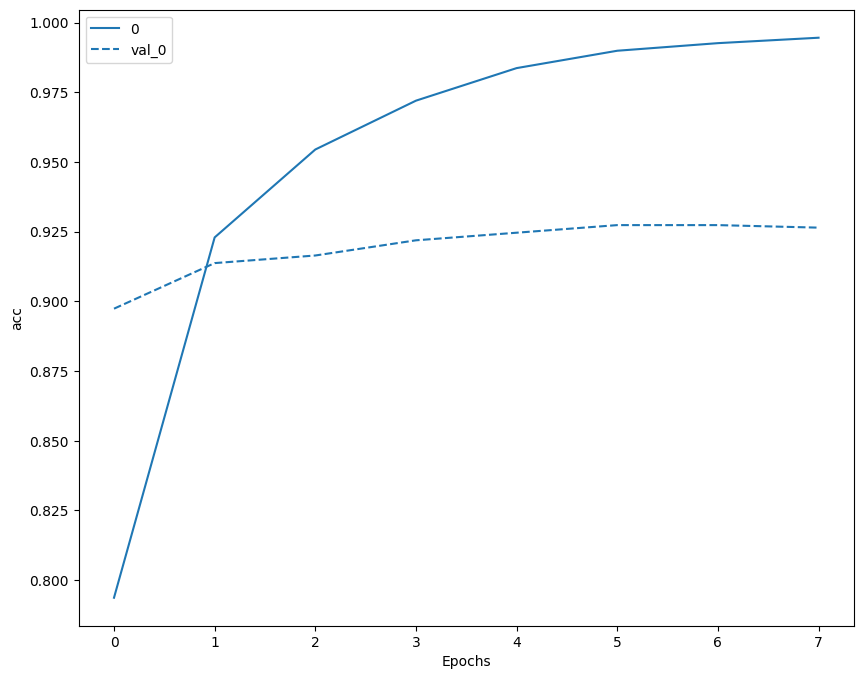

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))

plot_df = pd.DataFrame()

for i, history in enumerate(histories):
    method_name = str(i)
    history_df = pd.DataFrame(history.history)
    history_df['method_name'] = method_name
    history_df['Epochs'] = history_df.index
    plot_df = pd.concat([plot_df, history_df], ignore_index=True)

sns.lineplot(data=plot_df, x='Epochs', y='acc', hue='method_name')

val_plot_df = plot_df.copy()
val_plot_df['method_name'] = plot_df['method_name'].apply(lambda x: 'val_' + x)
sns.lineplot(data=val_plot_df, x='Epochs', y='val_acc', hue='method_name', linestyle='dashed')

plt.legend()
plt.show()

#BERT

In [45]:
# 必要なライブラリのインストール
!pip install transformers fugashi ipadic -q

import torch
from transformers import pipeline, BertTokenizer, BertModel
import torch.nn.functional as F

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. 感情分析（日本語） ---
print("\n=== 日本語感情分析 ===")

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="koheiduck/bert-japanese-finetuned-sentiment",
    device=0 if torch.cuda.is_available() else -1
)

texts = [
    "この映画は本当に素晴らしかった！",
    "今日は最悪の一日だった...",
    "まあまあの結果だと思う"
]

for text in texts:
    result = sentiment_pipeline(text)
    print(f"テキスト: {text}")
    print(f"  → {result[0]['label']}: {result[0]['score']:.4f}\n")


# --- 2. マスク予測 ---
print("\n=== マスク予測（穴埋め） ===")
fill_pipeline = pipeline(
    "fill-mask",
    model="cl-tohoku/bert-base-japanese-whole-word-masking",
    device=0 if torch.cuda.is_available() else -1
)

masked_text = "東京は日本の[MASK]です。"
results = fill_pipeline(masked_text)

print(f"入力: {masked_text}")
for r in results[:3]:
    print(f"  → {r['token_str']}: {r['score']:.4f}")


# --- 3. 文の埋め込み（類似度計算） ---
print("\n=== 文の類似度計算 ===")

tokenizer = BertTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking").to(device)
model.eval()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

sentences = [
    "機械学習はAIの一分野です",
    "人工知能には深層学習が含まれます",
    "今日の天気は晴れです"
]

embeddings = [get_embedding(s) for s in sentences]

print("文のペア間のコサイン類似度:")
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        sim = F.cosine_similarity(embeddings[i], embeddings[j]).item()
        print(f"  「{sentences[i][:15]}...」 vs 「{sentences[j][:15]}...」: {sim:.4f}")


# --- 4. 固有表現抽出（NER） ---
print("\n=== 固有表現抽出 ===")
ner_pipeline = pipeline(
    "token-classification",
    model="cl-tohoku/bert-base-japanese-whole-word-masking",
    aggregation_strategy="simple",
    device=0 if torch.cuda.is_available() else -1
)

# BERTの隠れ層を使った簡易的なキーワード抽出
print("重要トークンの抽出（Attention重みベース）:")

def extract_important_tokens(text, top_k=5):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # 最終層のAttention重みを平均
    attention = outputs.attentions[-1].mean(dim=1).mean(dim=1).squeeze()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze())

    # スコアでソート（[CLS], [SEP]を除く）
    token_scores = list(zip(tokens[1:-1], attention[1:-1].cpu().numpy()))
    token_scores.sort(key=lambda x: x[1], reverse=True)

    return token_scores[:top_k]

test_text = "東京大学の研究チームが人工知能を使った新しい医療診断システムを開発しました"
print(f"\n入力: {test_text}")
important = extract_important_tokens(test_text)
print("重要トークン:")
for token, score in important:
    print(f"  {token}: {score:.4f}")


# --- 5. 文書分類（BERTファインチューニングのデモ） ---
print("\n=== 簡易テキスト分類（コサイン類似度ベース） ===")

# カテゴリの代表文
categories = {
    "テクノロジー": "コンピューター、スマートフォン、AI、プログラミング",
    "スポーツ": "野球、サッカー、オリンピック、選手、試合",
    "料理": "レシピ、食材、調理、美味しい、レストラン"
}

# カテゴリ埋め込みを計算
category_embeddings = {cat: get_embedding(desc) for cat, desc in categories.items()}

def classify_text(text):
    text_emb = get_embedding(text)
    scores = {}
    for cat, cat_emb in category_embeddings.items():
        scores[cat] = F.cosine_similarity(text_emb, cat_emb).item()
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

test_texts = [
    "新しいiPhoneが発売されました",
    "日本代表がワールドカップで勝利",
    "簡単に作れるパスタのレシピを紹介"
]

for text in test_texts:
    print(f"\nテキスト: {text}")
    results = classify_text(text)
    for cat, score in results:
        print(f"  {cat}: {score:.4f}")

print("\n✅ 全てのデモが完了しました！")

Using device: cuda

=== 日本語感情分析 ===


Device set to use cuda:0


テキスト: この映画は本当に素晴らしかった！
  → POSITIVE: 0.9923

テキスト: 今日は最悪の一日だった...
  → NEGATIVE: 0.9901

テキスト: まあまあの結果だと思う
  → POSITIVE: 0.6407


=== マスク予測（穴埋め） ===


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


入力: 東京は日本の[MASK]です。
  → 地名: 0.1580
  → 首都: 0.1414
  → 中学校: 0.0810

=== 文の類似度計算 ===


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


文のペア間のコサイン類似度:
  「機械学習はAIの一分野です...」 vs 「人工知能には深層学習が含まれま...」: 0.7281
  「機械学習はAIの一分野です...」 vs 「今日の天気は晴れです...」: 0.7471
  「人工知能には深層学習が含まれま...」 vs 「今日の天気は晴れです...」: 0.6832

=== 固有表現抽出 ===


Some weights of BertForTokenClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


重要トークンの抽出（Attention重みベース）:

入力: 東京大学の研究チームが人工知能を使った新しい医療診断システムを開発しました
重要トークン:
  し: 0.0288
  システム: 0.0272
  しま: 0.0261
  発: 0.0240
  開: 0.0239

=== 簡易テキスト分類（コサイン類似度ベース） ===

テキスト: 新しいiPhoneが発売されました
  料理: 0.6794
  スポーツ: 0.6617
  テクノロジー: 0.6114

テキスト: 日本代表がワールドカップで勝利
  スポーツ: 0.7244
  料理: 0.7013
  テクノロジー: 0.6055

テキスト: 簡単に作れるパスタのレシピを紹介
  スポーツ: 0.7303
  料理: 0.7243
  テクノロジー: 0.6688

✅ 全てのデモが完了しました！
